In [7]:
# %pip install datasets sentence-transformers scikit-learn
%pip install datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: No matching distribution found for pywin32==306


# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [117]:
from datasets import load_dataset

dataset = load_dataset('google-research-datasets/go_emotions', split='train')


Print some examples

In [2]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [118]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('stsb-roberta-large')
sentences = dataset['text']
embeddings = model.encode(sentences, convert_to_tensor=False)
print(f"Shape of embeddings: {embeddings.shape}")


Shape of embeddings: (43410, 1024)


## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [73]:
import numpy as np
from scipy.spatial import distance

def euclidean_distance(a:np.ndarray, b:np.ndarray):
    #TODO
    return np.sqrt(np.sum(np.power(a-b, 2)))

def cosine_distance(a:np.ndarray, b:np.ndarray):
    #TODO
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    if norm_a == 0 or norm_b == 0:
        return 0
    cosine_sim = dot_product / (norm_a + norm_b)
    return float(cosine_sim)

def mahalanobis_distance(a:np.ndarray, b:np.ndarray, **kwargs):
    #TODO
    S = kwargs.get('inv_cov_matrix')
    if S is None:
            raise ValueError("Inverted covariance matrix must be provided for Mahalanobis distance.")
    a_b_diff = a - b
    # return np.sqrt(np.dot(np.dot(a_b_diff.T, S), a_b_diff))
    return np.sqrt(a_b_diff @ S @ a_b_diff.T)


def correlation_distance(a, b):
    #TODO
    # numerator = np.sum(a)
    # denominator =
    corr_dist = 1 - np.corrcoef(a, b)[0, 1] 
    return corr_dist

Implement custom K-Means class

In [31]:
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, distance_metric='euclidean',  **kwargs):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels_ = None
        self.kwargs = kwargs # inverted covariation matrix for mahalanodis disntace

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            self.labels_ = np.array([self._assign_label(x) for x in X])

            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) if len(X[self.labels_ == i]) > 0 else self.centroids[i] for i in range(self.n_clusters)])

            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def _assign_label(self, x):
        # assigns each data point to the nearest centroid based on the chosen distance metric.
        # method returns the index of the closest centroid, which represents the cluster assignment (or label) for the given data point x
        #TODO
        
        distances = self.centroids 
        if self.distance_metric == 'euclidean':
            distances = np.array([euclidean_distance(x, centroid) for centroid in self.centroids])
        elif self.distance_metric == 'mahalanobis':
            # Assuming the inverted covariance matrix is provided in kwargs
            # self.kwargs = 
            inv_cov_matrix = self.kwargs.get('inv_cov_matrix')
            if inv_cov_matrix is None:
                raise ValueError("Inverted covariance matrix must be provided for Mahalanobis distance.")
            distances = np.array([mahalanobis_distance(x, centroid, inv_cov_matrix=inv_cov_matrix) for centroid in self.centroids])
        elif self.distance_metric == 'correlation':
            distances = np.array([correlation_distance(x, centroid) for centroid in self.centroids])
        elif self.distance_metric == 'cosine':
            distances = np.array([cosine_distance(x, centroid) for centroid in self.centroids])
        else:
            raise ValueError("Unsupported distance metric")
        
        return np.argmin(distances)
    
        # return np.argmin(distances)


## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [137]:
n_clusters = 10
random_indices = np.random.choice(embeddings.shape[0], 50, replace=False)
# random_subset = X[random_indices]
sample_embed = embeddings[random_indices]

cov_matrix = np.cov(sample_embed.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
custom_kmeans = CustomKMeans(n_clusters=10, distance_metric='euclidean', inv_cov_matrix=inv_cov_matrix)
custom_kmeans.fit(sample_embed)

labels = custom_kmeans.labels_

print("Custom KMeans labels for the first 10 texts:")
print(labels[:10])


Custom KMeans labels for the first 10 texts:
[8 6 6 4 0 7 0 0 0 6]


In [146]:
orig_labels = dataset['labels'][:30]
orig_labels

[[27],
 [27],
 [2],
 [14],
 [3],
 [26],
 [15],
 [8, 20],
 [0],
 [27],
 [6],
 [1, 4],
 [27],
 [5],
 [3],
 [3, 12],
 [15],
 [2],
 [27],
 [6, 22],
 [6, 9, 27],
 [12],
 [27],
 [27],
 [27],
 [2],
 [27],
 [16, 25],
 [15],
 [27]]

it seems they also have uninformative labels(

In [138]:
text = dataset['text']
sample_text = [text[i] for i in random_indices]

for cluster in range(kmeans.n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [sample_text[i] for i in range(len(sample_text)) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Do you have the link to her GoFundMe?
- Just cleared normal mode! I'm having a lot of fun xD
- Wow thank you! I’m gonna do that!
- Aaaaand sold out.
- Don't hold your breath!

Cluster 1:
- Not all of us young teens eat tide pods Mom would be sad
- because your brain will associate the drip taste with the high after a few times, i love the drip
- This has been reposted so many times the photo is degrading.
- Hey and there are people who drink their urine too. Maybe try that next.
- Bridge trolls people, people trolls back the bridge, not sure what's happening now

Cluster 2:
- Whoops Ya probably shoulda put a /s there.
- Brb gotta go talk to my sister. And therapist.
- You’re*
- [NAME], [NAME] and [NAME] would like a word...
- My [NAME]. I think we have a winner. IT'S. A. REAL. PLACE. Best part

Cluster 3:
- Fus Ro D..omg the sun is coming up
- I actually like the progression of the [NAME] story. I think he has a chance to have a fantastic arc between FC5 and New Dawn.

Cl

## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.  
You should get something like this:

<a href="https://ibb.co/nRY9hQf"><img src="https://i.ibb.co/zNBpKPb/output.png" alt="output" border="0"></a>

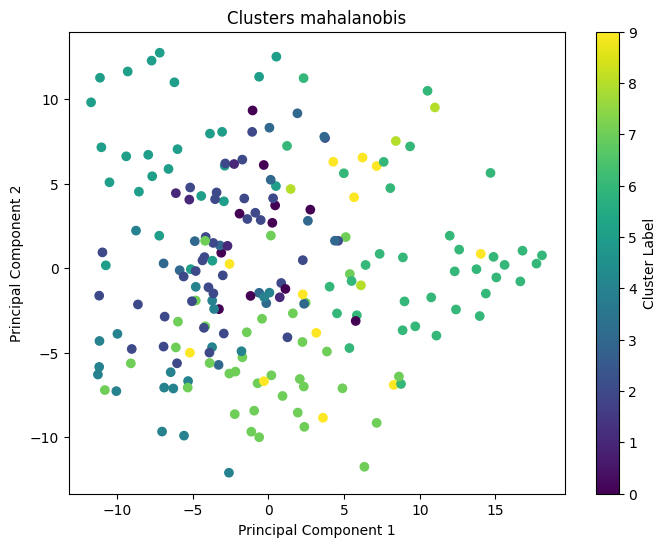

In [98]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters(X, labels, mectric, n_components=2):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title(f'Clusters {mectric}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster Label')
    plt.grid()
    plt.show()

visualize_clusters(sample_embed, labels, 'mahalanobis')

<class 'numpy.ndarray'>
euclidean is done


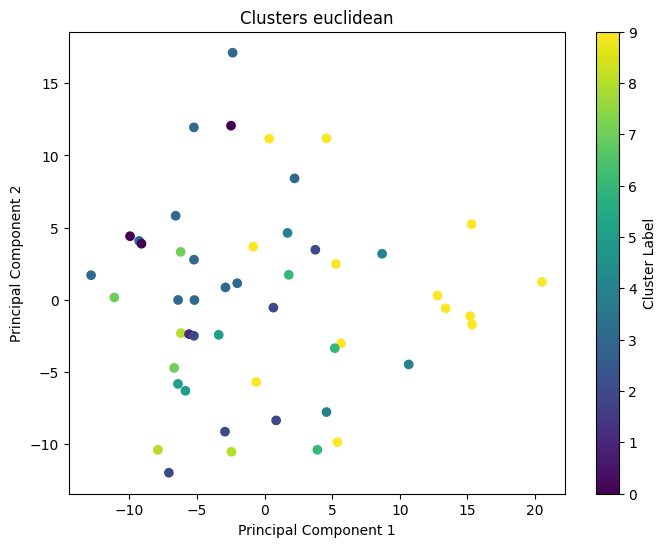

/tmp/ipykernel_3077/2875665437.py:30: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(a_b_diff @ S @ a_b_diff.T)


mahalanobis is done


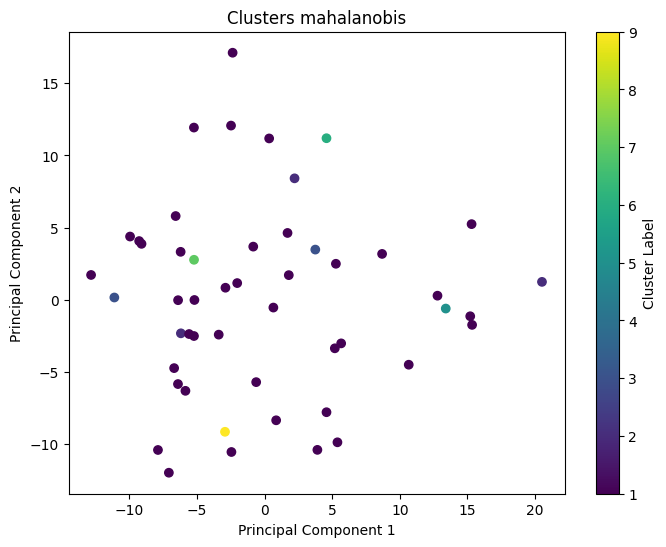

cosine is done


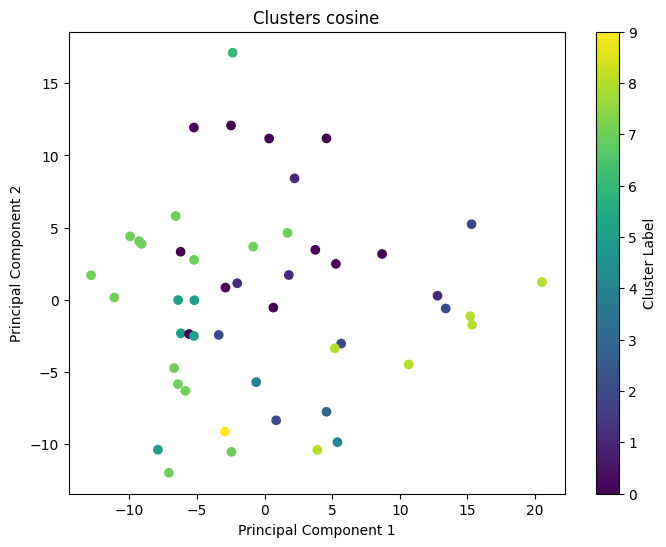

correlation is done


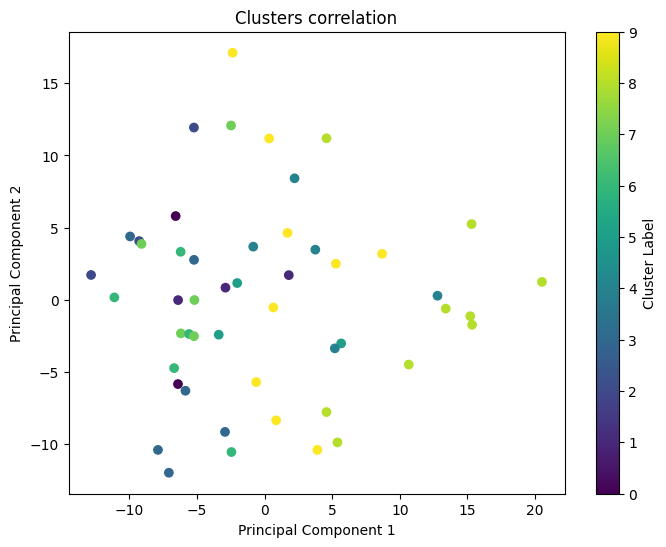

In [105]:
metric_lst = ['euclidean', 'mahalanobis', 'cosine', 'correlation']
print(type(embeddings))
random_indices = np.random.choice(embeddings.shape[0], 50, replace=False)
# random_subset = X[random_indices]
sample_emb = embeddings[random_indices]


for metric in metric_lst:
    if metric == 'mahalanobis':
        cov_matrix = np.cov(sample_emb.T)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        kmeans = CustomKMeans(n_clusters=10, distance_metric=metric, inv_cov_matrix=inv_cov_matrix)
        kmeans.fit(sample_emb)
        label = kmeans.labels_
    else:
        kmeans = CustomKMeans(n_clusters=10, distance_metric=metric)
        kmeans.fit(sample_emb)
        label = kmeans.labels_
    print(f'{metric} is done')
    # print(sample_emb.shape)
    # print(label.shape)
    visualize_clusters(sample_emb, label, metric)
    



euclidean is done


/tmp/ipykernel_3077/2875665437.py:30: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(a_b_diff @ S @ a_b_diff.T)


mahalanobis is done
cosine is done
correlation is done


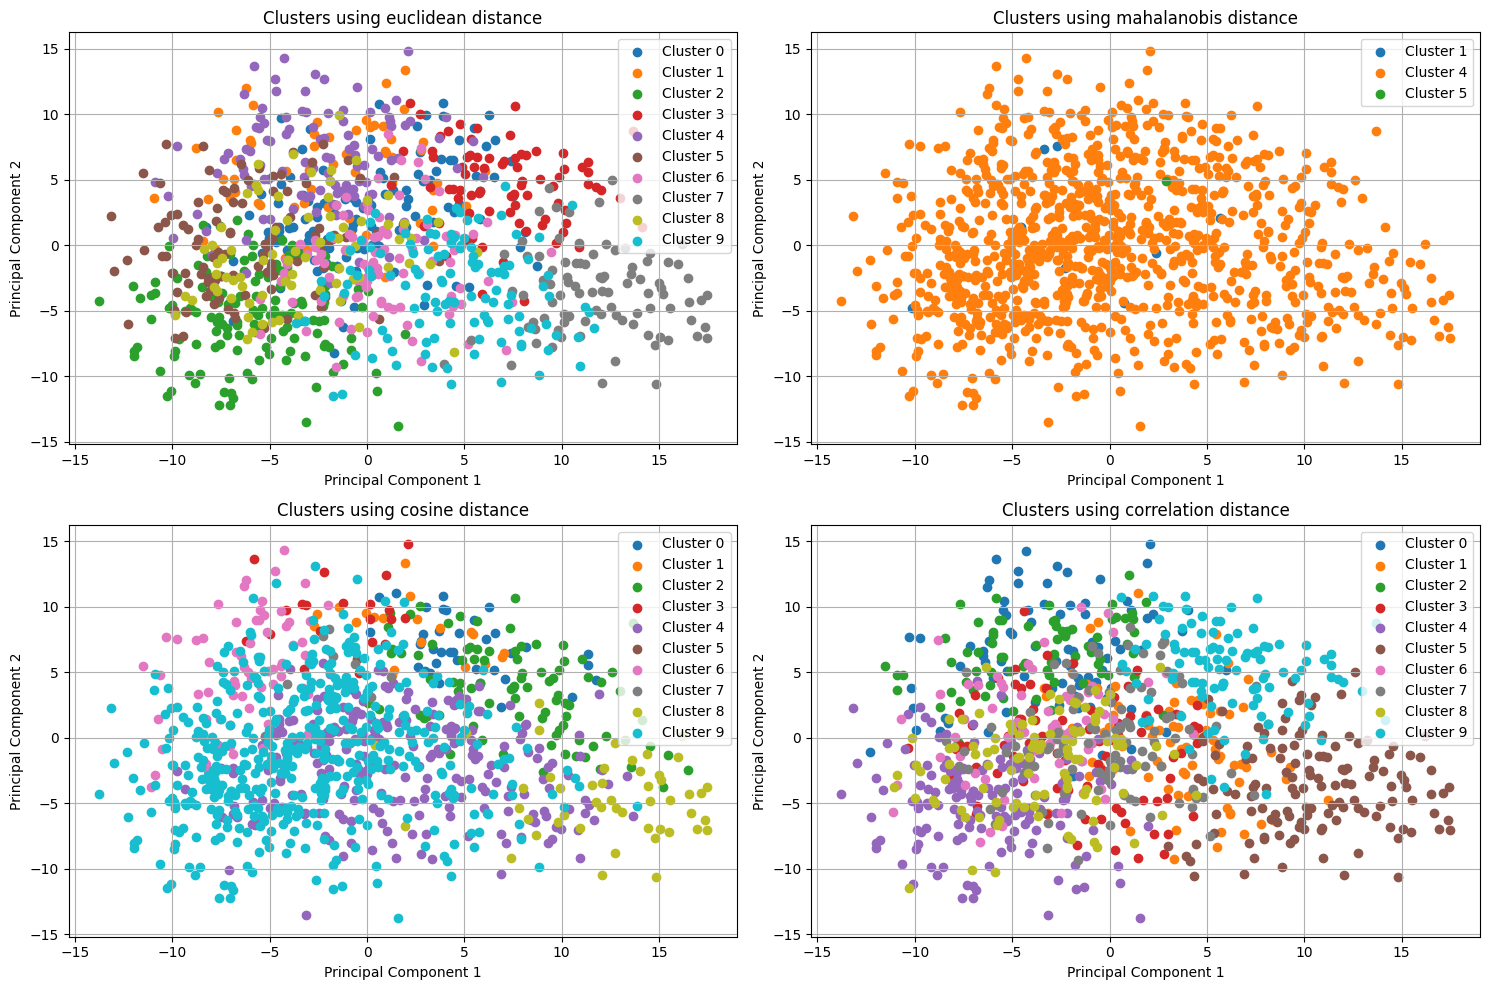

In [147]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
metric_lst = ['euclidean', 'mahalanobis', 'cosine', 'correlation']
random_indices = np.random.choice(embeddings.shape[0], 1000, replace=False)
sample_emb = embeddings[random_indices]


import seaborn as sns
def visualize_clusters(X, labels, metric, ax):
    """
    Visualize the clusters in 2D space using PCA.

    Parameters:
    X (np.ndarray): The data matrix.
    labels (np.ndarray): The cluster labels.
    metric (str): The distance metric used.
    ax (matplotlib.axes.Axes): The subplot to plot on.
    """
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    for i in np.unique(labels):
        ax.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], label=f'Cluster {i}')
        # sns.scatterplot(x = X_reduced[labels == i, 0], y = X_reduced[labels == i, 1])
    ax.set_title(f'Clusters using {metric} distance')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.grid()
    ax.legend()

# Iterate over the distance metrics and plot each cluster in a separate subplot
for i, metric in enumerate(metric_lst):
    if metric == 'mahalanobis':
        cov_matrix = np.cov(sample_emb.T)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        kmeans = CustomKMeans(n_clusters=10, distance_metric=metric, inv_cov_matrix=inv_cov_matrix)
        kmeans.fit(sample_emb)
        label = kmeans.labels_
    else:
        kmeans = CustomKMeans(n_clusters=10, distance_metric=metric)
        kmeans.fit(sample_emb)
        label = kmeans.labels_
    
    print(f'{metric} is done')
    
    # Plot the clusters in the corresponding subplot
    row = i // 2
    col = i % 2
    visualize_clusters(sample_emb, label, metric, axs[row, col])
plt.tight_layout()
plt.show()


    
# Adjust the layout


Let's print examples of the text for each cluster

## 6. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

Well that was very very long time for processing, different types of metrics, now i found out why exactly cosine similarity is so broadly used. Compare to euclidian distanse its simlier to interpretate (-1, 1) compare to (0, inf). Both mahalanobis, and correlation calculation is extremely slow (which is a problem for production solutions).